In [1]:
!pip install keras

# https://www.kaggle.com/code/arunponnusamy/generating-handwritten-digits-with-dcgan

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.optimizers import Adam

2024-05-28 17:14:03.074812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 17:14:03.838681: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/nvidia/cuda_cupti/lib/:/home/sudarsun/.local/lib/python3.10/site-packages/nvidia/cuda_runtime/lib/:
2024-05-28 17:14:03.838767: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBR

In [2]:
class DCGAN:
    @staticmethod
    def build_generator(dim, depth, channels=1, inputDim=100, outputDim=512):

        model = Sequential()

        inputShape = (dim, dim, depth)
        chanDim = -1


        model.add(Dense(units=outputDim, input_dim=inputDim))
        model.add(Activation("relu"))
        model.add(BatchNormalization())

        model.add(Dense(dim * dim * depth))
        model.add(Activation("relu"))
        model.add(BatchNormalization())

        model.add(Reshape(inputShape))
        model.add(Conv2DTranspose(32, (5,5), strides=(2,2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        model.add(Conv2DTranspose(channels, (5,5), strides=(2,2), padding="same"))
        model.add(Activation("tanh"))

        return model

    @staticmethod
    def build_discriminator(width, height, depth, alpha=0.2):

        model = Sequential()
        inputShape = (height, width, depth)

        model.add(Conv2D(32, (5,5), padding="same", strides=(2,2),
                    input_shape=inputShape))
        model.add(LeakyReLU(alpha=alpha))


        model.add(Conv2D(64, (5,5), padding="same", strides=(2,2)))
        model.add(LeakyReLU(alpha=alpha))

        model.add(Flatten())
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=alpha))

        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        return model

In [3]:
!pip install imutils

Defaulting to user installation because normal site-packages is not writeable


In [4]:
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.datasets import mnist
from sklearn.utils import shuffle
from imutils import build_montages
import numpy as np
import argparse
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
NUM_EPOCHS = 20
BATCH_SIZE = 128

print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
trainImages = np.concatenate([trainX, testX])

print(trainX.shape)
print(trainImages.shape)

trainImages = np.expand_dims(trainImages, axis=-1)
trainImages = (trainImages.astype("float") - 127.5) / 127.5

[INFO] loading MNIST dataset...
(60000, 28, 28)
(70000, 28, 28)


In [6]:
print("[INFO] building generator...")
gen = DCGAN.build_generator(7, 64)

[INFO] building generator...


2024-05-28 17:15:48.312290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-28 17:15:48.359177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-28 17:15:48.359391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-28 17:15:48.359872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [7]:
print("[INFO] building discriminator...")
disc = DCGAN.build_discriminator(28, 28, 1)
discOpt = Adam(learning_rate=0.0002, beta_1=0.5, decay=0.0002 / NUM_EPOCHS)
disc.compile(loss="binary_crossentropy", optimizer=discOpt)

[INFO] building discriminator...


In [8]:
print("[INFO] building GAN...")
disc.trainable = False
ganInput = Input(shape=(100,))
ganOutput = disc(gen(ganInput))
gan = Model(ganInput, ganOutput)

print(gan.summary())

ganOpt = Adam(learning_rate=0.0002, beta_1=0.5, decay=0.0002 / NUM_EPOCHS)
gan.compile(loss="binary_crossentropy", optimizer=discOpt)

[INFO] building GAN...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         1727233   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1658753   
                                                                 
Total params: 3,385,986
Trainable params: 1,719,873
Non-trainable params: 1,666,113
_________________________________________________________________
None


In [9]:
print("[INFO] starting training...")
benchmarkNoise = np.random.uniform(-1, 1, size=(256, 100))
output_dir = os.getcwd()

for epoch in range(NUM_EPOCHS):

    print("[INFO] starting epoch {} of {}...".format(epoch + 1, NUM_EPOCHS))
    batchesPerEpoch = int(trainImages.shape[0] / BATCH_SIZE)

    for i in range(0, batchesPerEpoch):

        p = None

        imageBatch = trainImages[i * BATCH_SIZE: (i + 1) * BATCH_SIZE]
        noise = np.random.uniform(-1, 1, size=(BATCH_SIZE, 100))

        genImages = gen.predict(noise, verbose=0)

        X = np.concatenate((imageBatch, genImages))
        y = np.array(([1] * BATCH_SIZE) + ([0] * BATCH_SIZE))
        (X, y) = shuffle(X, y)

        discLoss = disc.train_on_batch(X, y)

        noise = np.random.uniform(-1, 1, (BATCH_SIZE, 100))
        ganLoss = gan.train_on_batch(noise, np.array([1] * BATCH_SIZE))

        if i == batchesPerEpoch - 1:
            p = [output_dir, "epoch_{}_output.png".format(str(epoch + 1).zfill(4))]

        if p is not None:
            print("[INFO] Step {}_{}: discriminator_loss={:.6f}, "
                "adversarial_loss={:.6f}".format(epoch+1, i, discLoss, ganLoss))

            images = gen.predict(benchmarkNoise)
            images = ((images * 127.5) + 127.5).astype("uint8")
            images = np.repeat(images, 3, axis=-1)
            vis = build_montages(images, (28,28), (16,16))[0]

            p = os.path.sep.join(p)
            cv2.imwrite(p, vis)

[INFO] starting training...
[INFO] starting epoch 1 of 20...


2024-05-28 17:17:40.284181: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-28 17:17:40.439155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700


[INFO] Step 1_545: discriminator_loss=0.254996, adversarial_loss=2.331775
8/8 [==============================] - 0s 1ms/step
[INFO] starting epoch 2 of 20...
[INFO] Step 2_545: discriminator_loss=0.388230, adversarial_loss=1.459452
8/8 [==============================] - 0s 1ms/step
[INFO] starting epoch 3 of 20...
[INFO] Step 3_545: discriminator_loss=0.441492, adversarial_loss=1.613401
8/8 [==============================] - 0s 1ms/step
[INFO] starting epoch 4 of 20...
[INFO] Step 4_545: discriminator_loss=0.456354, adversarial_loss=1.368537
8/8 [==============================] - 0s 1ms/step
[INFO] starting epoch 5 of 20...
[INFO] Step 5_545: discriminator_loss=0.470803, adversarial_loss=1.421760
8/8 [==============================] - 0s 2ms/step
[INFO] starting epoch 6 of 20...
[INFO] Step 6_545: discriminator_loss=0.448209, adversarial_loss=1.449848
8/8 [==============================] - 0s 1ms/step
[INFO] starting epoch 7 of 20...
[INFO] Step 7_545: discriminator_loss=0.445716, adve

In [10]:
!ls epoch_*.png

epoch_0001_output.png  epoch_0008_output.png  epoch_0015_output.png
epoch_0002_output.png  epoch_0009_output.png  epoch_0016_output.png
epoch_0003_output.png  epoch_0010_output.png  epoch_0017_output.png
epoch_0004_output.png  epoch_0011_output.png  epoch_0018_output.png
epoch_0005_output.png  epoch_0012_output.png  epoch_0019_output.png
epoch_0006_output.png  epoch_0013_output.png  epoch_0020_output.png
epoch_0007_output.png  epoch_0014_output.png


In [12]:
# create gif, 2 frames per second
import subprocess
subprocess.call([
    'ffmpeg', '-framerate', '2', '-i', \
    'epoch_%04d_output.png', 'dcgan_output.gif'
])

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

0

In [13]:
from IPython.display import Image

# define image_url variable
image_url = 'dcgan_output.gif'

# display image using url and specific width set at 500
Image(url=image_url, width=500)

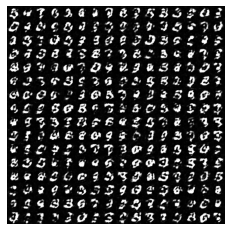

In [14]:
out = cv2.imread("epoch_0001_output.png")
plt.axis("off")
plt.imshow(out)